In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import arya

In [2]:
data = pd.read_csv("data/Sculptor_DARTS_BEST_psat40.csv")
data["r_ell"] = data["Elliptical radius"]
data["RV"] =  data.vel
data["RV_err"] = data.evel

Text(0, 0.5, 'RV / km/s')

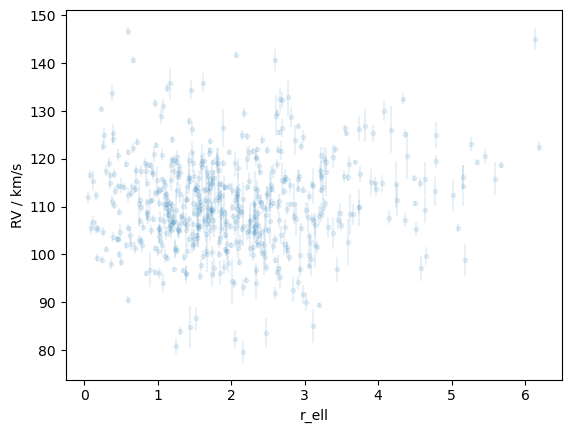

In [3]:
plt.errorbar(data.r_ell, data.vel, yerr = data.RV_err, fmt=".", alpha=0.1)

plt.xlabel("r_ell")
plt.ylabel("RV / km/s")

In [4]:
import emcee

In [5]:
import numpy as np
import random
import corner
import emcee
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.io import fits

see @walker2006 

In [9]:
def log_like(params, obs, unc, N):
    """
    Log likelihood function for the product of two normally distributed distributions.
    Parameters that will be maximized: true mean (mu), instrinsic dispersion, (sig)
    Parameters passed in: observed value (obs), measured uncertainty (unc)
    """
    mu, sig = params
    return -0.5*np.sum(np.log(unc**2 + sig**2)) - 0.5*np.sum((obs-mu)**2/(unc**2 + sig**2)) - N/2*np.log(2*np.pi)
    
def log_vprior(params):
    """
    Flat priors for velocity mean and dispersion. Set the constraints that work best for your data.
    """
    mu, sig = params
    if 70 < mu < 150 and 5 < sig < 15.0:
        return 0.0
    return -np.inf

def log_vprob(params, obs, unc, N):
    """
    Combined log probability function.
    """
    lp = log_vprior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_like(params, obs, unc, N)


In [10]:
#IMPORT DATA HERE

#Uncomment when you have imported data
#obs = DATA -- VELOCITIES
#unc = DATA -- VELOCITY UNCERTAINTIES
N = len(data)

#Modify the number of walkers, as well as the region to drop your walkers. I auggest use the full range within your flat priors.
nwalkers = 64
mu_walk = np.random.uniform(70, 100, size=nwalkers)
sig_walk = np.random.uniform(0, 10, size=nwalkers)

p0 = np.array([mu_walk, sig_walk]).T
ndim = 2

samplerv = emcee.EnsembleSampler(
    nwalkers, ndim, log_vprob, args=(data.RV, data.RV_err, N)
)

#Pl
steps_run = 10000
steps_toss = 2000
samplerv.run_mcmc(p0, steps_run, progress=True);

  0%|                                                       | 0/10000 [00:00<?, ?it/s]/Users/daniel/miniconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|███████████████████████████████████████████| 10000/10000 [02:55<00:00, 57.01it/s]


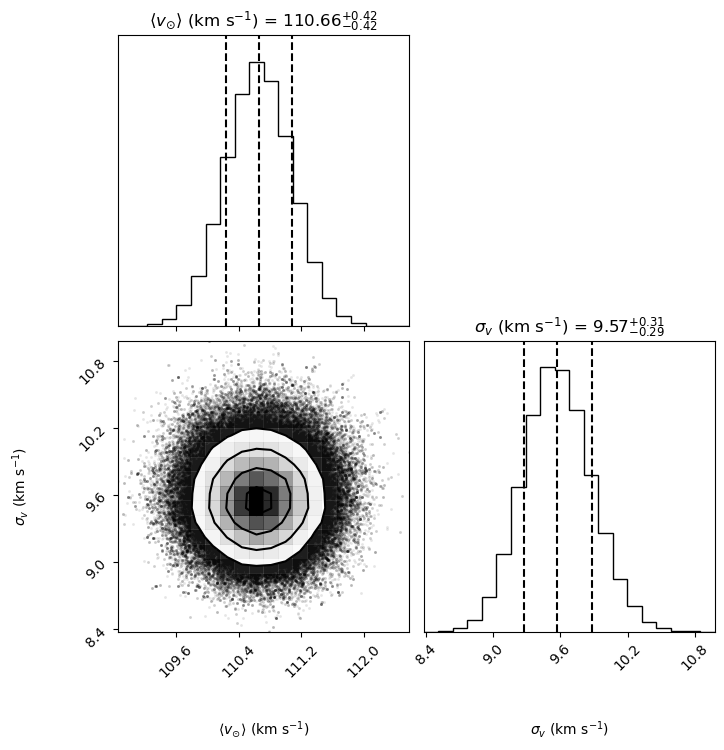

In [11]:
#Corner plot
flat_samplesv = samplerv.get_chain(discard=steps_toss, flat=True)
labels = [r"$\langle v_{\odot}\rangle$ (km s$^{-1}$)", r"$\sigma_v$ (km s$^{-1}$)"]
label_unit = r"km s$^{-1}$"

value = np.median(flat_samplesv, axis=0)
vels = np.quantile(flat_samplesv.T[0], [0.16, 0.50, 0.84])
disps = np.quantile(flat_samplesv.T[1], [0.16, 0.50, 0.84])

fig = corner.corner(
    flat_samplesv, labels=labels, quantiles=[0.16, 0.5, 0.84], 
    show_titles=True, color='k', title_fmt='.2f'
)
fig.set_figwidth(8)
fig.set_figheight(8)